# **Project Title:** House Price Prediction for Properties in Major Cities of Pakistan


`Dataset`: [Pakistan House Price Dataset](https://www.kaggle.com/datasets/jillanisofttech/pakistan-house-price-dataset/data)  


# **About Dataset**
## Context
The dataset is scraped from zameen.com which is Pakistan's top real estate platform. It contains listings of properties from five major cities of Pakistan.  
The aim of this project is to perform Exploratory Data Analysis (EDA) to uncover insights and use Machine Learning models to predict property price based on the given attributes.  

### **Content**
#### Column Descriptions:
`property_id`: Unique identifier for each property.  
`location_id`: Unique identifier for each location within a city.  
`page_url`: The URL of the webpage where the property was published.  
`property_type`: Categorization of the property into six types: House, FarmHouse, Upper Portion, Lower Portion, Flat, or Room.  
`price`: The price of the property, which is the dependent feature in this dataset.  
`city`: The city where the property is located. The dataset includes five cities: Lahore, Karachi, Faisalabad, Rawalpindi, and Islamabad.  
`province`: The state or province where the city is located.  
`location`: Different types of locations within each city.  
`latitude` and `longitude`: Geographic coordinates of the cities.  




---

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV, cross_val_score,KFold

import joblib

import warnings
warnings.filterwarnings('ignore')


In [44]:
df = pd.read_csv('cleaned_data.csv')

In [45]:
df.nunique()

property_type        7
price             1676
city                 5
province_name        3
baths                9
purpose              2
bedrooms             8
area_sqft          227
price_per_sqft    9692
year_added           2
dtype: int64

In [46]:
df.head()

,property_type,price,city,province_name,baths,purpose,bedrooms,area_sqft,price_per_sqft,year_added
0,Flat,10000000,Islamabad,Islamabad Capital,2,For Sale,2,1088.0,9191.176471,2019
1,Flat,6900000,Islamabad,Islamabad Capital,3,For Sale,3,1523.2,4529.936975,2019
2,House,16500000,Islamabad,Islamabad Capital,6,For Sale,5,2176.0,7582.720588,2019
3,House,43500000,Islamabad,Islamabad Capital,4,For Sale,4,10890.0,3994.490358,2019
4,House,7000000,Islamabad,Islamabad Capital,3,For Sale,3,2176.0,3216.911765,2019


### Splitting Dataset

In [47]:
#splitting dataset
X = df.drop(['price'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [48]:
cat_features = X.select_dtypes(include=['object']).columns
cat_features

Index(['property_type', 'city', 'province_name', 'purpose'], dtype='object')

Target encoding on location (try it)

In [49]:
# # Compute mean price per location on TRAINING data only
# location_mean_price = X_train.join(y_train).groupby('location')['price'].mean()

# # Map to both train and test
# X_train['location'] = X_train['location'].map(location_mean_price)
# X_test['location'] = X_test['location'].map(location_mean_price)

# # Fill unknown locations in test set with overall mean
# mean_price_overall = y_train.mean()
# X_test['location'].fillna(mean_price_overall, inplace=True)

In [50]:


# Define which columns get which scaler
numeric_features_2 = ['area_sqft', 'bedrooms', 'baths']                 # skewed, outliers
categorical_features = ['city', 'property_type', 'purpose','province_name']   

# Define transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num_robust', RobustScaler(), numeric_features_2),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [51]:
# Create the full pipeline with preprocessor and regressor( trying different regressors)
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.1),
    "LightGBM": LGBMRegressor(random_state=42, n_estimators=200, learning_rate=0.1),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42, iterations=300, learning_rate=0.1),
    # "SVR": SVR(kernel='rbf', C=100, epsilon=0.1),
    "KNN": KNeighborsRegressor(n_neighbors=5)
    
}

results = {}
best_model = None
best_model_name = None
best_r2 = float(0.0)

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"{name}: R² = {r2}, MSE = {mse}")
    
    # Update best model if this one is better
    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_model_name = name

print(f"\nBest Model: {best_model_name} with R² = {best_r2}")



Linear Regression: R² = 0.5108400990204698, MSE = 65294748942713.47
Random Forest: R² = 0.8411651695190155, MSE = 21201820424868.25
Gradient Boosting: R² = 0.8065943851274764, MSE = 25816447836228.133
XGBoost: R² = 0.83982914686203, MSE = 21380156358656.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 104893, number of used features: 20
[LightGBM] [Info] Start training from score 10570953.665021
LightGBM: R² = 0.84327290814176, MSE = 20920472211465.277
CatBoost: R² = 0.8347627426191593, MSE = 22056438426493.207
KNN: R² = 0.8251764194982606, MSE = 23336053865553.91

Best Model: LightGBM with R² = 0.84327290814176


### Hyperparameter Tuning

In [52]:
best_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [53]:
# # choose best parameters based for lightgbm
# param_grid = {
#     'num_leaves': [31, 50, 100],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 300, 500],
#     'max_depth': [-1, 10, 20, 30],
#     'subsample': [0.6, 0.8, 1.0],
#     'feature_fraction': [0.6, 0.8, 1.0],
# }

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', best_model)
# ])


# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid={'regressor__' + k: v for k, v in param_grid.items()},
#     scoring='r2',
#     cv=3,
#     n_jobs=-1,
#     verbose=2
# )

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best R² Score:", grid_search.best_score_)

# best_model = grid_search.best_estimator_



using randomizedSearchCV because GridSearch taking too long to run

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint  # for distributions (optional)

# parameters = {
#     'num_leaves': randint(31, 150),
#     'learning_rate': uniform(0.01, 0.1),
#     'n_estimators': randint(100, 800),
#     'max_depth': [-1, 10, 20, 30],
#     'subsample': uniform(0.6, 0.4),        # 0.6 to 1.0
#     'feature_fraction': uniform(0.6, 0.4)  # 0.6 to 1.0
# }

parameters = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'max_depth': [-1, 10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'feature_fraction': [0.6, 0.8, 1.0],
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])


random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions={'regressor__' + k: v for k, v in parameters.items()},
    scoring='r2',
    cv=3,
    n_iter=100,        
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best R² Score:", random_search.best_score_)

best_model = random_search.best_estimator_


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 104893, number of used features: 20
[LightGBM] [Info] Start training from score 10570953.665021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

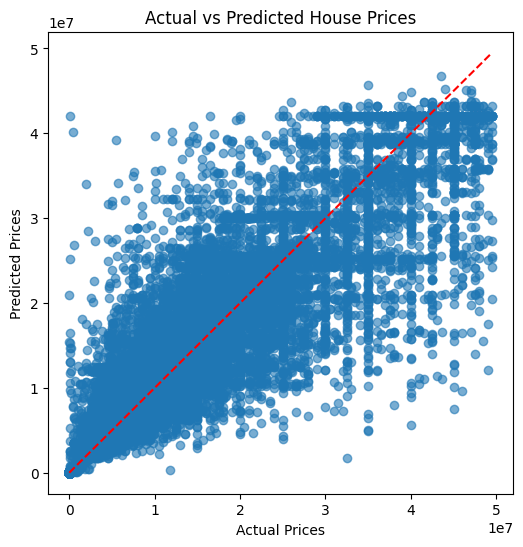

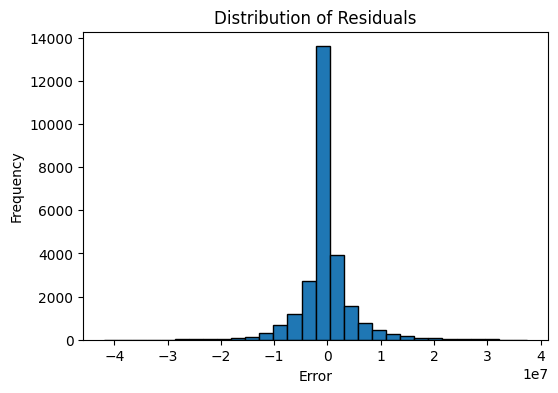

In [55]:

# 1️⃣ True vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# 2️⃣ Residual Plot (errors)
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


In [56]:
X_train.columns

Index(['property_type', 'city', 'province_name', 'baths', 'purpose',
       'bedrooms', 'area_sqft', 'price_per_sqft', 'year_added'],
      dtype='object')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

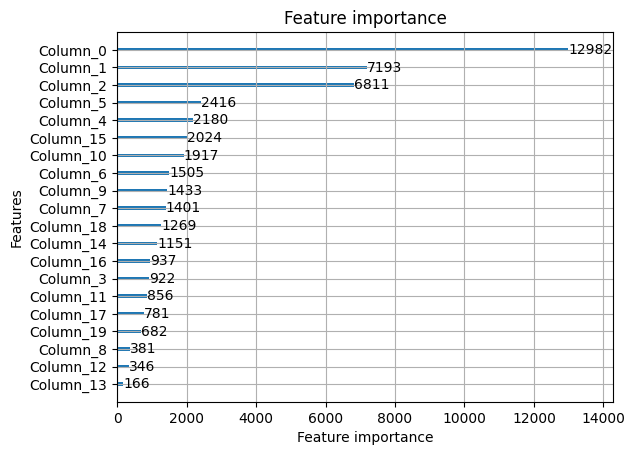

In [57]:
# import matplotlib.pyplot as plt
import lightgbm as lgb
lgb.plot_importance(best_model['regressor'])


In [58]:
from sklearn.model_selection import cross_val_score, KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X, y, cv=cv, scoring='r2')
print(scores.mean(), scores.std())


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 104893, number of used features: 20
[LightGBM] [Info] Start training from score 10570953.665021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [61]:

joblib.dump(best_model, 'model.pkl')


['model.pkl']

In [60]:
## for loading

# model = joblib.load('model.pkl')
# y_pred = model.predict(new_data)